# VAE Autoencoder

#### By [Natalí de Santi](https://natalidesanti.github.io), email: natalidesanti@gmail.com

In this notebook we will see an **image denoising** technique produced by a **VAE autoencoder**.

## 0) Summary

* Image denoising using autoencoders
* Variation Autoencoders
* Libraries
* Data
* Building the Autoencoder
* Training the model
* Testing the model

## 1) Image denoising using autoencoders

`Autoencoding` is a data compression algorithm where we have the **compression** and the **decompression** functions that are: 

_data-specific_, _lossy_, and _learned automatically from examples_.

That is the reason why that, differently from the _traditional methods_ we have seen before, this new category of _image denoising methods_
are purely **data-driven**, what means there is no need to phocus on a specific kind of noise.

A **autoencoder** can be a __deep Learning algorithm__ which takes an _input image_, assign _importance_ (learnable weight, biases and 
retains spatial relationships in the data into each one of theirs layers) to various aspects/parts in the image and is able to 
differentiate/reconstruct the same.

The general idea behind this kind of code can be visualized here:

![General autoencoder](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png)
###### Figure: Example of a general autoencoder

Then, the **autoencoder** compreehends an _encoder_ and a _decoder_. 

The **encoder** does the _encoding process_, i.e., transforms the image into a _compressed representation_ at the same time that starts the noisy reduction. 

Then, the _compressed representation_ goes to **decoder** that performs the _decoder process_, restoring the image to its true and recognizable shape. 

The encoder and decoder are usually chosen as _parametric function_, here represented by **neural networks**, and the _parameters_ of the encoding/decoding functions are optimized to minimize the **loss function**, which is a measure of the difference between the _denoised image_ and the _true_ one.

At the end of the process, we remove almost all noise in the image.

## 2) Variational Autoencoders

**Variational Autoencoders** (VAE) is a type of autoencoder with **added constraints** on the _encoded representations being learned_. 

More precisely, it is an autoencoder that **learns a latent variable model** for its _input data_. 

So instead of letting the neural network learn an arbitrary function, it is _learning the parameters of a probability distribution modeling your data_. 

If we sample points from this distribution, we can generate new input data samples: a VAE is a **generative model**.

In a VAE, an **encoder network** _turns_ the input samples $x$ into two parameters in a **latent space**, which can be denoted as `z_mean` and `z_log_sigma`. 

Then, similar $z$ points are _randomly sampled_ from the _latent normal distribution_ that is assumed to **generate the data**:
\begin{equation}
z = z\_mean + exp(z\_log\_sigma) * epsilon,
\end{equation}
where `epsilon` is a random normal tensor. 

Finally, a **decoder network** _maps_ these latent space points _back to the original input data_.

The parameters of the model are trained via _two loss functions_: 
* A reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders)
* KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term.

It is important to note that because of the generative essence of this model, the model is really **data-hungry**, needing _lots of data_ to explore all the options of the latent space.

Due to this reason I will show how to use a VAE to remove noise from one class of digits!

## 3) Libraries

Once again, the libraries are subject to your installation (see notebook of image denoising).

Here, we will implement the **CNNautoencoder** using `keras`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Reshape

#To solve the problem with tensorflow version!
import tensorflow._api.v2.compat.v1 as tf

In [2]:
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


## 4) Data

As detailed in the first notebook, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

### Importing data

In [25]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [26]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

Let's select only handwritten digits of the number $2$:

In [27]:
x_train = x_train[np.where(y_train == 2)]
y_train = y_train[np.where(y_train == 2)]

x_test = x_test[np.where(y_test == 2)]
y_test = y_test[np.where(y_test == 2)]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5958, 28, 28), (5958,), (1032, 28, 28), (1032,))

In [28]:
dimension = x_train.shape[1]
dimension

28

### Pre-processing data

We are going to normalize the images between 0 and 1 and to reshape them.

In [29]:
norm_factor = 255.

x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor

x_train = np.reshape(x_train, (len(x_train), dimension, dimension, 1))
x_test = np.reshape(x_test, (len(x_test), dimension, dimension, 1))

x_train.shape, x_test.shape

((5958, 28, 28, 1), (1032, 28, 28, 1))

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [30]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images.

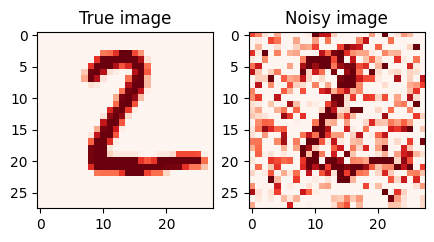

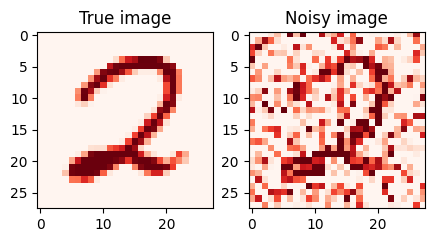

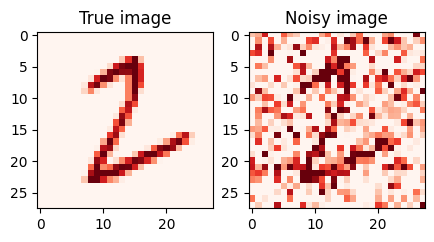

In [9]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## 5) Building the Autoencoder

In [10]:
original_dim = 784
latent_dim = 16
epochs = 40
epsilon_std = 0.5
noise_factor = 0.55
validation_split = 0.2

### Encoder

In [11]:
x_noise = Input(shape = (28, 28, 1))
x = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(x_noise)
x = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

We can use these parameters to **sample** new similar points from the _latent space_:

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], 
                                       latent_dim), mean = 0.,
                              stddev = epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [13]:
z = Lambda(sampling, output_shape = (latent_dim,))([z_mean, z_log_var])
z = Reshape([1, 1, latent_dim])(z)

### Decoder

In [14]:
x = Conv2DTranspose(128, (1, 1), padding = 'valid', activation = 'relu')(z)
x = Conv2DTranspose(64, (3, 3), padding = 'valid', activation = 'relu')(x)
x = Conv2DTranspose(64, (3, 3), padding = 'valid', activation = 'relu')(x)
x = Conv2DTranspose(48, (3, 3), strides = (2, 2), padding = 'same',activation='relu')(x)
x = Conv2DTranspose(48, (3, 3), padding = 'valid', activation = 'relu')(x)
x = Conv2DTranspose(32, (3, 3), strides = (2, 2), padding = 'same',activation='relu')(x)
x = Conv2DTranspose(16, (3, 3), padding = 'valid', activation = 'relu')(x)
x_out = Conv2DTranspose(1, (3, 3), padding = 'valid', activation = 'sigmoid')(x)

### Autoencoder

In [15]:
# instantiate VAE model
vae = Model(x_noise, x_out)

We can visualize the **autoencoder**:

In [16]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 16)           160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 64)           9280      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## 6) Training the model

Before starting training, we have to configure our model to use a **per-pixel** `binary crossentropy` _loss_, and the `Adam` _optimizer_:

In [17]:
# Compute VAE loss
def VAE_loss(x_origin, x_out):
    x_origin = K.flatten(x_origin)
    x_out = K.flatten(x_out)
    xent_loss = original_dim * metrics.binary_crossentropy(x_origin, x_out)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

In [18]:
vae.compile(optimizer = 'adam', loss = VAE_loss)

### Fitting

Time to learn how to denoise the image by fiting/training the method.

Notice that we are defining a portion of the training set to validate the model at each epoch:

In [19]:
history = vae.fit(x_train_noisy, x_train, epochs = 40, batch_size = 32, validation_split = validation_split)

Train on 4766 samples, validate on 1192 samples
Epoch 1/40
 128/4766 [..............................] - ETA: 7s - loss: 540.9823 

2024-09-27 11:32:48.362071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-09-27 11:32:48.386112: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/conv2d_transpose_7/kernel/v/Assign' id:1072 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_transpose_7/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_transpose_7/kernel/v, training/Adam/conv2d_transpose_7/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4736/4766 [============================>.] - ETA: 0s - loss: 267.6886

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2024-09-27 11:32:50.946179: W tensorflow/c/c_api.cc:305] Operation '{name:'loss/mul' id:467 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/conv2d_transpose_7_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


4766/4766 [==============================] - 3s 602us/sample - loss: 267.2992 - val_loss: 202.9536
Epoch 2/40
4766/4766 [==============================] - 3s 607us/sample - loss: 187.5044 - val_loss: 169.0018
Epoch 3/40
4766/4766 [==============================] - 3s 630us/sample - loss: 152.3166 - val_loss: 144.0598
Epoch 4/40
4766/4766 [==============================] - 3s 648us/sample - loss: 137.6370 - val_loss: 135.4466
Epoch 5/40
4766/4766 [==============================] - 3s 665us/sample - loss: 131.6027 - val_loss: 131.0999
Epoch 6/40
4766/4766 [==============================] - 3s 681us/sample - loss: 126.9574 - val_loss: 127.6924
Epoch 7/40
4766/4766 [==============================] - 3s 687us/sample - loss: 123.2478 - val_loss: 123.9070
Epoch 8/40
4766/4766 [==============================] - 3s 728us/sample - loss: 120.1238 - val_loss: 121.8737
Epoch 9/40
4766/4766 [==============================] - 4s 741us/sample - loss: 118.2518 - val_loss: 120.6515
Epoch 10/40
4766/4766

### Tracking the history of the training stage

Now, we can analise the model taking a look at the losses for the **training** and **validations** sets:

In [20]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [21]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training:

Text(0.5, 0, 'Epochs')

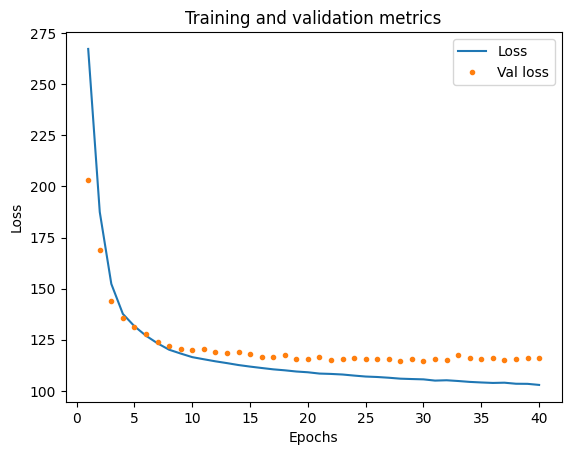

In [22]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, '.', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

## 7) Testing the model

We can now take a look at the performance of our model by _testing_ it on the _test set_:

In [31]:
x_denoised = vae.predict(x_test, batch_size = 32)
x_denoised = np.array(x_denoised)

In [32]:
x_denoised.shape

(1032, 28, 28, 1)

### Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

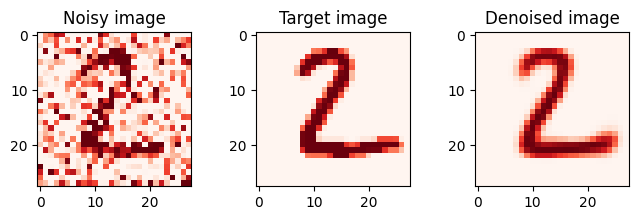

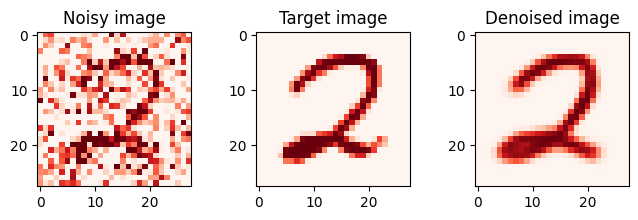

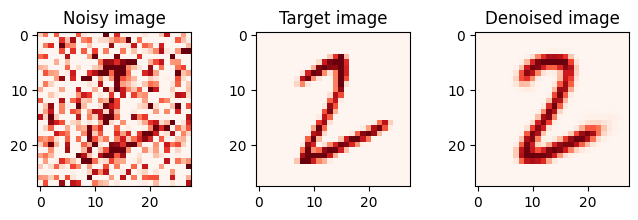

In [34]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(x_denoised[i, :, :, 0].reshape(dimension, dimension), cmap = 'Reds')

These images are almost perfect and they are similar to the results we found with the **CNNautoencoder**!

## References

[1] FAN, L. et al. Brief review of image denoising techniques. Visual Computing for Industry, Biomedicine, and Art, v. 2, 2019.

[2] Tian, C. et al. Deep Learning on Image Denoising: An overview. arXiv e-prints, p. arXiv:1912.13171, dez. 2019.

[3] Chollet, F. [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[4] de SANTI, N. S. M. Machine learning methods for extracting cosmological information. 2024. doi: [10.11606/T.43.2024.tde-15072024-101341](https://www.teses.usp.br/teses/disponiveis/43/43134/tde-15072024-101341/en.php).